In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import tdgl
from tdgl.geometry import box, circle
from tdgl.visualization.animate import create_animation
from tdgl.sources import LinearRamp, ConstantField
from typing import Optional, Sequence, Union, Tuple
import pint
from matplotlib.transforms import Affine2D
import matplotlib as mpl
import copy
import cmath
import glob
import shutil
import re


os.environ["OPENBLAS_NUM_THREADS"] = "1"
plt.rcParams["figure.figsize"] = (5, 4)

C:\Users\draid\anaconda3\Lib\site-packages\cupyx\jit\_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [3]:
project_name = "J7__no_antidot"

In [89]:
points_filepath = os.getcwd() + "/extracted_data/extracted_points.h5"
with h5py.File(points_filepath, 'r') as f:
    experimental_data = [tuple(row) for row in f['tuples'][:]]

print("Extracted data loaded from " + points_filepath + "\n")
# print(reconstructed_data)

simulation_ranges = [] #[(N, b_min, b_max), ...]
vortex_count = 0
b_fields = [b for n, b, i in experimental_data]
# Calculate min and max
if b_fields:  # Check if the filtered list is not empty
    min_b = min(b_fields)
    max_b = max(b_fields)
    simulation_ranges.append((vortex_count, min_b, max_b))
else:
    print("No values found for the specified vortex_count.")
        
print("Simulation Ranges: " + str(simulation_ranges))

Extracted data loaded from D:\Documents\0Purdue\Research\Rokhinson Lab\CPR-Extraction/extracted_data/extracted_points.h5

Simulation Ranges: [(0, -0.014696869, 0.014706869)]


In [5]:
def make_video_from_solution(
    solution,
    output_file=None,
    quantities=("order_parameter", "phase"),
    fps=20,
    figsize=(5, 4),
):
    """Generates an HTML5 video from a tdgl.Solution."""
    with tdgl.non_gui_backend():
        with h5py.File(solution.path, "r") as h5file:
            anim = create_animation(
                h5file,
                output_file=output_file,
                quantities=quantities,
                fps=fps,
                figure_kwargs=dict(figsize=figsize),
            )
            #Return early if just saving to file
            if(output_file!=None):
                return
            video = anim.to_html5_video()
        return HTML(video)

In [6]:
#Extracted from Jian's data from 03/13/2024

jj_length = 260e-9 #m
jj_width = 2000e-9 #m
jj_bz_min = 2e-3 #T
phi0 = 2.067833848e-15 #Wb

jj_flux = phi0
jj_area=jj_flux/jj_bz_min
jj_length_eff = jj_area/jj_width
jj_lambda= (jj_length_eff-jj_length)/2
print("Lambda: " + str(round(jj_lambda*1e9, 2)) + " nm")

electrode_width = 0.3 #um
hole_size = 0.8 #um

junction_length = 0.110 #um, 120 by design, 100-110 in real device.

Lambda: 128.48 nm


In [76]:
length_units = "um"
# Material parameters
xi = 0.2
d = 0.1
big_lambda = 0.3


london_lambda = jj_lambda*1e6 #np.sqrt(d*big_lambda)


layer = tdgl.Layer(coherence_length=xi, london_lambda=london_lambda, thickness=d, gamma=1)

# Device geometry
total_width = electrode_width*2+hole_size
total_length = electrode_width*2+hole_size
hole_size = hole_size

# Top Right Notch
right_notch = (
    tdgl.Polygon("right_notch", points=box((total_width-electrode_width)/2, total_length-electrode_width))
    .translate(dx=(total_width+electrode_width)/3.9, dy=electrode_width/1.9999)
    .resample(401)
    
)

# Top Right Notch
left_notch = (
    tdgl.Polygon("right_notch", points=box((total_width-electrode_width)/2, total_length-electrode_width))
    .translate(dx=-(total_width+electrode_width)/3.9, dy=electrode_width/1.9999)
    .resample(401)
    
)

film = (
    tdgl.Polygon("film", points=box(total_width, total_length))
    .difference(right_notch, left_notch)
    .resample(401)
    # .buffer(0)
)


# Holes in the film
square_hole = (
    tdgl.Polygon("square_hole", points=box(hole_size, hole_size))
    .resample(401)
    
)


In [77]:
device = tdgl.Device(
    "antidot",
    layer=layer,
    film=film,
#     holes=[square_hole],
    # terminals=[source, drain],
    # probe_points=probe_points,
    # length_units=length_units,
)

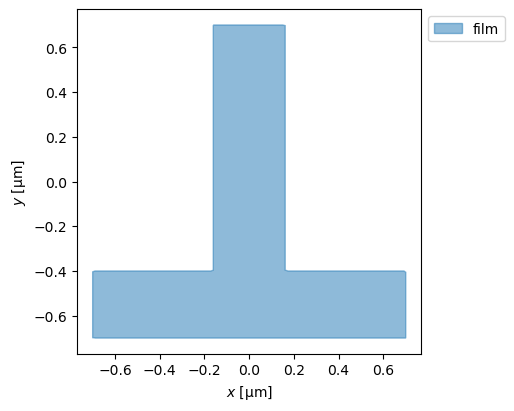

In [78]:
fig, ax = device.draw()

In [79]:
device.make_mesh(max_edge_length=xi / 2, smooth=100)

Constructing Voronoi polygons: 100%|███████████████████████████████████████████████████████████████████████████| 1426/1426 [00:01<00:00, 1316.38it/s]


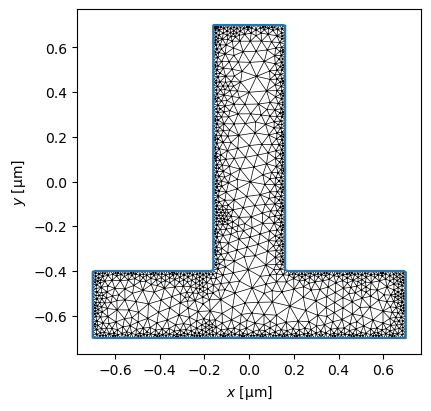

In [80]:
fig, ax = device.plot(mesh=True, legend=False)

In [81]:
# This generates a radially symmetric function for psi using psi(r) and the desired number of vortices.
# It could very easily be replaced to a non-symmetric function
# The other degree of freedom is the mu_boundary that is currently left as zero like the default.
def psi_ansatz(center, vortex_count, psi_radial, points):
    #Note that x, y coordinates and center coordinates must be given in dimensionless coordinates
    x_center = center[0]
    y_center = center[1]
    x = points[:, 0]
    y = points[:, 1]
    phi = np.arctan2((y-y_center),(x-x_center))
    r = np.sqrt((x-x_center)**2 + (y-y_center)**2)
    return np.exp(vortex_count*1j*phi) * psi_radial(r)

def generate_ansatz(device, options, applied_vector_potential, center, vortex_count, psi_radial):
    # This runs a short (time=1) simulation to generate a Solution object easily.
    # This could be done other ways too, but this is short and larger modifications
    # would be better left to the package itself.
    # It then edits the TDGLData object
    
    print("Solving 1 time step to generate most of solution object")
    initial_options = tdgl.SolverOptions(
        solve_time=1,
        field_units = options.field_units,
        current_units = options.current_units,
    )
    solution = tdgl.solve(
        device=device,
        options=initial_options,
    )
    
    print("Calculating Replacement TDGLData")
    
    # Directly create a solver to reuse the ability to calculate mu, super_current, and normal current
    # I would use the one that was used in tdgl.solve but it is not returned. It would be easy to edit
    # the package so that the solver is returned for situations like this. the defaults are copied from
    # Solve.py.  solve_for_observables references some built in properties of the solver: default options, operators, 
    # and mu_boundary. The default options are clearly okay to reference. The operators that are referenced
    # are not changed after they are set during initialization assuming that A remains zero.  This means that the
    # operators are initialized properly for when solver.solve_for_observables is called.
    # solver.mu_boundary is the only parameter that may need to be set, but since no current is flowing into
    # or out of the device, I think it is fair to leave it as it is initialized.  mu_boundary is typically all
    # zero and remains zero when no current is applied.
    
    solver = tdgl.solver.solver.TDGLSolver(
        device=device,
        options=options,
        applied_vector_potential=0,
        terminal_currents=None,
        disorder_epsilon=1,
        seed_solution=None,
    )
    
    new_psi = psi_ansatz(center, vortex_count, psi_radial, solution.device.mesh.sites)
    new_mu, new_supercurrent, new_normal_current = solver.solve_for_observables(psi=new_psi, dA_dt=0)
    
    replacement_data = tdgl.solution.data.TDGLData(
        step=-1,  #Last step
        epsilon=solution.tdgl_data.epsilon, #Leave the same since this is just a physical parameter
        psi=new_psi, #This directly uses the psi_ansatz function defined above
        mu=new_mu, # Calculated using new_psi
        applied_vector_potential=applied_vector_potential, # User Parameter
        induced_vector_potential=np.zeros((len(solution.device.mesh.edge_mesh.edges), 2)), # No screening current, this is zero until a solve step screening is performed  
        supercurrent=new_supercurrent, # Calculated using new_psi
        normal_current=new_normal_current, # Calculated using new_psi
        state=solution.tdgl_data.state, # This should be fine to leave as-is. It just contains {'dt', 'step', 'time', 'timestamp'}
    )
    
    print("Replacing TDGLData")
    solution.tdgl_data = replacement_data
    
    print("Finished Calculating Ansatz")
    return solution
    

In [82]:
#Adjusted constant field that is symmetrical about (0,0) instead of center of mass
def custom_uniform_Bz_vector_potential(
    positions: np.ndarray,
    Bz: Union[float, str, pint.Quantity],
) -> np.ndarray:
    """Calculates the magnetic vector potential [Ax, Ay, Az] at ``positions``
    due uniform magnetic field along the z-axis with strength ``Bz``.

    Args:
        positions: Shape (n, 3) array of (x, y, z) positions in meters at which to
            evaluate the vector potential.
        Bz: The strength of the uniform field, as a pint-parseable string,
            a pint.Quantity, or a float with units of Tesla.

    Returns:
        Shape (n, 3) array of the vector potential [Ax, Ay, Az] at ``positions``
        in units of Tesla * meter.
    """
    ureg = tdgl.em.ureg
    assert isinstance(Bz, (float, str, pint.Quantity)), type(Bz)
    positions = np.atleast_2d(positions)
    assert positions.shape[1] == 3, positions.shape
    if not isinstance(positions, pint.Quantity):
        positions = positions * ureg("meter")
    if isinstance(Bz, str):
        Bz = ureg(Bz)
    if isinstance(Bz, float):
        Bz = Bz * ureg("tesla")
    xs = positions[:, 0]
    ys = positions[:, 1]
    dx = np.ptp(xs)
    dy = np.ptp(ys)
    xs = xs #- (xs.min() + dx / 2)#Do not shift so we can take advantage of symmetry
    ys = ys #- (ys.min() + dy / 2)#Do not shift so we can take advantage of symmetry
    Ax = -Bz * ys / 2
    Ay = Bz * xs / 2
    A = np.stack([Ax, Ay, np.zeros_like(Ax)], axis=1)
    return A.to("tesla * meter")

#Adjusted constant field that is symmetrical about (0,0) instead of center of mass
def custom_constant_field_vector_potential(
    x,
    y,
    z,
    *,
    Bz: float,
    field_units: str = "mT",
    length_units: str = "um",
):
    ureg = tdgl.em.ureg
    if z.ndim == 0:
        z = z * np.ones_like(x)
    positions = np.array([x.squeeze(), y.squeeze(), z.squeeze()]).T
    positions = (positions * ureg(length_units)).to("m").magnitude
    Bz = Bz * ureg(field_units)
    A = custom_uniform_Bz_vector_potential(positions, Bz)
    return A.to(f"{field_units} * {length_units}").magnitude

#Adjusted constant field that is symmetrical about (0,0) instead of center of mass
def custom_ConstantField(
    value: float = 0, field_units: str = "mT", length_units: str = "um"
) -> tdgl.Parameter:
    """Returns a Parameter that computes a constant as a function of ``x, y, z``.
    Args:
        value: The constant value of the field.
    Returns:
        A Parameter that returns ``value`` at all ``x, y, z``.
    """
    return tdgl.Parameter(
        custom_constant_field_vector_potential,
        Bz=float(value),
        field_units=field_units,
        length_units=length_units,
    )

In [83]:
def calculate_solution(field_strength, initial_vortex_count, save_file, seed_solution=None):
    # field_strength = 5
    
    global project_name
#     initial_vortex_count = 0

    options_no_screening = tdgl.SolverOptions(
        solve_time=250,
        field_units = "mT",
        current_units="uA",
        output_file=save_file,
        save_every=800,
        include_screening=False,
    )

    applied_A = custom_ConstantField(field_strength, field_units=options_no_screening.field_units, length_units=device.length_units)
    
    print("Calculating for Field", field_strength)
    try:
        solution = tdgl.Solution.from_hdf5(save_file)
        print("No Screening Solution Already Exists")
    except FileNotFoundError as e:
        print("No Screening Existing solution not found. Solving.")

        if(seed_solution is None):
            seed_solution = generate_ansatz(
                device=device,
                options=options_no_screening,
                applied_vector_potential=applied_A,#Set this to be what you want to test after generating the ansatz
                center=(0,0),
                vortex_count=initial_vortex_count,
                psi_radial= lambda r: 1 - np.exp(-.2*r),
            )
            

        solution = tdgl.solve(
            device,
            options=options_no_screening,
            applied_vector_potential=applied_A,
            seed_solution=seed_solution,
        )
    return solution, applied_A

In [84]:
def recalculate_solution_with_screening(field_strength, initial_vortex_count, seed_solution, save_file):
    global project_name

    options_with_screening = tdgl.SolverOptions(
        solve_time=10,
        field_units = "mT",
        current_units="uA",
        output_file=save_file,
        save_every=800,
        include_screening=True,
    )

    applied_A = custom_ConstantField(field_strength, field_units=options_with_screening.field_units, length_units=device.length_units)
    
    try:
        solution = tdgl.Solution.from_hdf5(save_file)
        print("Screening Solution Already Exists")
    except FileNotFoundError as e:
        print("Screening solution not found. Solving.")

        solution = tdgl.solve(
            device,
            options=options_with_screening,
            applied_vector_potential=applied_A,
            seed_solution=seed_solution,
        )
    return solution, applied_A

In [85]:
def calculate_edge_current(solution, x_list, thickness):

#    # Plot segment
#     fig, axes = plt.subplots(1, 2, figsize=(6, 4))
#     _ = solution.plot_currents(ax=axes[0], streamplot=False)
#     _ = solution.plot_currents(ax=axes[1])

    #Take current through a short segment on the border
    ymin =  -total_length/2-0.001
    ymax = ymin + 0.01
    y = np.linspace(ymin, ymax, 401)
    x = x_list * np.ones_like(y)
    cross_section = np.array([x, y]).T

    current = solution.current_through_path(cross_section)/((ymax-ymin-0.001)*1e-6)/thickness
    return current

def plot_edge_currents(x, currents):
    plt.plot(x, currents)
    plt.title("Edge Current")
    plt.xlabel("X_coordinate [um]")
    plt.ylabel("edge_current_density [A/m^2]")
    plt.show()
    
def plot_currents(solution):
   # Plot segment
    fig, axes = plt.subplots(1, 2, figsize=(6, 4))
    _ = solution.plot_currents(ax=axes[0], streamplot=False)
    _ = solution.plot_currents(ax=axes[1])
    plt.show()

In [86]:
def calculate_x_phase(x, currents, field_strength):
    global london_lambda, junction_length
    phi0 = 2.067833848e-15 #Wb
    u0 = 1.256637*1e-6 #N*A**(-2)
    eta = (2*np.pi/phi0) * ((london_lambda*1e-6)**2*u0) #Constant in units of m/A
    x_phase = [(-2*eta*current + 2*np.pi*field_strength*(1e-3)*junction_length*1e-6/phi0)*x_i for (current, x_i) in zip(currents, x)]
    return x_phase
    
def plot_x_phase(x, x_phase):
    plt.plot(x, x_phase)
    plt.title("Guage Invariant Phase (Pre-Optimization)")
    plt.ylabel("Phase")
    plt.xlabel("X_coordinate [um]")
    plt.show()
    
def plot_psi(solution, show = True):
    fig, axes = solution.plot_order_parameter(figsize=(5.5, 4))
    if(show):
        plt.show()
        
    return fig, axes

In [96]:
def get_newest_file(directory):
    files = glob.glob(os.path.join(directory, '*'))
    return max(files, key=os.path.getmtime)

def get_vortex_count(solution):
    solution.solve_step = -1
    phases = solution.boundary_phases()["square_hole"].phases
    vortex_count = ((phases[-1]-phases[0])/(2*np.pi))
    return vortex_count

# Calculate New Solutions
simulation_b_count = 50
video_counter = 0
for initial_vortex_count, b_min, b_max in simulation_ranges:
    # Skip some simulations for now.
#     if(initial_vortex_count < -4 or initial_vortex_count > 4):
#         continue
    for field_strength in np.linspace(b_min*1000, b_max*1000, simulation_b_count): #Convert B field to mT
        save_file=os.getcwd() + "/solutions/" + project_name + "/no_screening/" + "field_" + str(field_strength) + "_vortex_" + str(initial_vortex_count) + ".h5"
        calculate_solution(field_strength, initial_vortex_count, save_file)
        solution = tdgl.Solution.from_hdf5(save_file)
        if(video_counter%5==0):
            solution_name = get_newest_file(os.getcwd() + "/solutions/" + project_name + "/no_screening/").split("\\")[-1]
            try:
                #Generate the video if it doesn't exit
                video_filename = os.getcwd() + "/videos/" + project_name + "/no_screening/" + solution_name[:-3] + ".mp4"
                if not(os.path.exists(video_filename)):
                    pass
#                     make_video_from_solution(solution, output_file=video_filename)
            except FileNotFoundError as e:
                print("Error Loading Solution: " + solution)
                print(e)

        destination_file = os.getcwd() + "/solutions/" + project_name + "/stable_no_screening/" + "field_" + str(field_strength) + "_vortex_" + str(initial_vortex_count) + ".h5"
        shutil.copy(save_file, destination_file)
        video_counter += 1


Calculating for Field -14.696869067847729
No Screening Solution Already Exists
Calculating for Field -14.096792787313461
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  2.14tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [05:46<00:00,  1.39s/tau ]


Calculating for Field -13.496716506779194
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  4.61tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:40<00:00,  1.56tau/s ]


Calculating for Field -12.896640226244926
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  5.83tau/s ]

Calculating Replacement TDGLData


Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:49<00:00,  2.29tau/s ]


Calculating for Field -12.296563945710659
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  8.60tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:51<00:00,  2.25tau/s ]


Calculating for Field -11.696487665176392
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  7.33tau/s ]

Calculating Replacement TDGLData


Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:51<00:00,  2.24tau/s ]


Calculating for Field -11.096411384642124
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  8.11tau/s ]

Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz



Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:51<00:00,  2.24tau/s ]


Calculating for Field -10.496335104107857
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  7.41tau/s ]

Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz



Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:53<00:00,  2.20tau/s ]


Calculating for Field -9.89625882357359
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  7.13tau/s ]

Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz



Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:53<00:00,  2.21tau/s ]


Calculating for Field -9.296182543039322
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  8.55tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:54<00:00,  2.19tau/s ]


Calculating for Field -8.696106262505054
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  7.11tau/s ]

Calculating Replacement TDGLData


Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:57<00:00,  2.13tau/s ]


Calculating for Field -8.096029981970787
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  6.41tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:55<00:00,  2.17tau/s ]


Calculating for Field -7.49595370143652
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  8.65tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:54<00:00,  2.19tau/s ]


Calculating for Field -6.895877420902252
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  8.29tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:56<00:00,  2.15tau/s ]


Calculating for Field -6.295801140367985
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  8.93tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:55<00:00,  2.16tau/s ]


Calculating for Field -5.695724859833717
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  8.80tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:55<00:00,  2.16tau/s ]


Calculating for Field -5.09564857929945
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  8.95tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:54<00:00,  2.18tau/s ]


Calculating for Field -4.4955722987651825
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  7.06tau/s ]

Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz



Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:57<00:00,  2.12tau/s ]


Calculating for Field -3.895496018230915
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  7.33tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:58<00:00,  2.11tau/s ]


Calculating for Field -3.2954197376966476
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  8.67tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:55<00:00,  2.16tau/s ]


Calculating for Field -2.69534345716238
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  8.55tau/s ]

Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz



Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:57<00:00,  2.12tau/s ]


Calculating for Field -2.095267176628113
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  9.42tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:58<00:00,  2.11tau/s ]


Calculating for Field -1.4951908960938454
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  8.27tau/s ]

Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz



Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:58<00:00,  2.11tau/s ]


Calculating for Field -0.8951146155595779
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  8.94tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:57<00:00,  2.13tau/s ]


Calculating for Field -0.2950383350253105
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  8.78tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:58<00:00,  2.11tau/s ]


Calculating for Field 0.3050379455089569
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  8.53tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:57<00:00,  2.13tau/s ]


Calculating for Field 0.9051142260432243
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  8.19tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:57<00:00,  2.12tau/s ]


Calculating for Field 1.5051905065774918
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  8.51tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:56<00:00,  2.14tau/s ]


Calculating for Field 2.105266787111759
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  9.24tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:57<00:00,  2.12tau/s ]


Calculating for Field 2.7053430676460266
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  8.57tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:02<00:00,  2.05tau/s ]


Calculating for Field 3.305419348180294
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  9.06tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:57<00:00,  2.13tau/s ]


Calculating for Field 3.9054956287145615
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  6.08tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:57<00:00,  2.12tau/s ]


Calculating for Field 4.505571909248829
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  5.55tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:59<00:00,  2.10tau/s ]


Calculating for Field 5.105648189783096
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  8.30tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:55<00:00,  2.17tau/s ]


Calculating for Field 5.705724470317364
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  7.87tau/s ]

Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz



Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [02:01<00:00,  2.06tau/s ]


Calculating for Field 6.305800750851631
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  7.37tau/s ]

Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz



Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:49<00:00,  2.28tau/s ]


Calculating for Field 6.905877031385899
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  9.22tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:48<00:00,  2.31tau/s ]


Calculating for Field 7.505953311920166
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  8.77tau/s ]

Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz



Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:50<00:00,  2.27tau/s ]


Calculating for Field 8.106029592454433
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  9.15tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:47<00:00,  2.33tau/s ]


Calculating for Field 8.7061058729887
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  8.09tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:48<00:00,  2.31tau/s ]


Calculating for Field 9.306182153522968
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  8.57tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:49<00:00,  2.29tau/s ]


Calculating for Field 9.906258434057236
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  9.24tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:47<00:00,  2.32tau/s ]


Calculating for Field 10.506334714591503
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  8.78tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:46<00:00,  2.34tau/s ]


Calculating for Field 11.10641099512577
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  7.85tau/s ]

Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz



Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:47<00:00,  2.33tau/s ]


Calculating for Field 11.706487275660038
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  9.92tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:46<00:00,  2.35tau/s ]


Calculating for Field 12.306563556194305
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  8.46tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:47<00:00,  2.33tau/s ]


Calculating for Field 12.906639836728573
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  8.92tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:42<00:00,  2.44tau/s ]


Calculating for Field 13.50671611726284
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  8.55tau/s ]

Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz



Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:41<00:00,  2.46tau/s ]


Calculating for Field 14.106792397797108
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  7.56tau/s ]

Calculating Replacement TDGLData


Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:40<00:00,  2.48tau/s ]


Calculating for Field 14.706868678331375
No Screening Existing solution not found. Solving.
Solving 1 time step to generate most of solution object


Simulating:  80%|████████████████████████████████████████████████████████████████████████████████                    | 1/1 [00:00<00:00,  8.78tau/s ]


Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 250/250 [01:38<00:00,  2.53tau/s ]


In [97]:
def get_closest_solution(target_field_strength, target_vortex_count, folder):
    try:
        pattern = r'field_([-+]?\d*\.\d+|\d+)_vortex_([-+]?\d+)'
        single_vortex_files = [
            file for file in os.listdir(folder)
            if (match := re.search(pattern, file)) and int(match.group(2)) == target_vortex_count
        ]
        field_strengths = [
            float(re.search(pattern, file).group(1)) for file in single_vortex_files
        ]

        closest_index = np.argmin(np.abs(np.array(field_strengths) - target_field_strength))

        # Get the corresponding filename
        closest_file = single_vortex_files[closest_index]
        closest_float = field_strengths[closest_index]

        # Print the file with the smallest float value
        print(f'File with the closest field: {closest_file}')
        print(f'Closest field value: {closest_file}')
        return closest_file
    except Exception as e:
        return None 
    
# # Redo the simulations that jumped using the closest calculated solution
no_screening_folder = os.getcwd() + "/solutions/" + project_name + "/no_screening/"
stable_no_screening_folder = os.getcwd() + "/solutions/" + project_name + "/stable_no_screening/"
screening_folder = os.getcwd() + "/solutions/" + project_name + "/no_screening/"

no_screening_files = os.listdir(no_screening_folder)
stable_no_screening_files = os.listdir(stable_no_screening_folder)

simulation_points = []
for file_name in no_screening_files:
    file_pattern = r'field_([-+]?\d*\.\d+|\d+)_vortex_([-+]?\d+)'
    match = re.search(file_pattern, file_name)
    if match:
        field_strength = float(match.group(1))
        initial_vortex_count = int(match.group(2))
        simulation_points.append((file_name, field_strength, initial_vortex_count))
    else:
        print("WARNING: Corrupt filenames present in ./solutions/no_screening")

for vortex_count_to_simulate in np.unique([point[2] for point in simulation_points]):
    
    #Sort the required simulations by absolute value
    single_vortex_list = sorted([point for point in simulation_points if point[2] == vortex_count_to_simulate], key=lambda point: abs(point[1]))
    for sim_point in single_vortex_list:
        file_name = sim_point[0]
        field_strength = sim_point[1]
        initial_vortex_count = sim_point[2]

        #Determine the seed solution. If a screening solution has been generated, start with that one.
        # Its probably close. Otherwise, use the no_screening_solution
        screening_folder    = os.getcwd() + "/solutions/" + project_name + "/screening/"
        stable_screening_folder    = os.getcwd() + "/solutions/" + project_name + "/stable_screening/"
        stable_no_screening_folder = os.getcwd() + "/solutions/" + project_name + "/stable_no_screening/"
        seed_sol_file_name = get_closest_solution(field_strength, initial_vortex_count, stable_screening_folder)
        if(seed_sol_file_name is None):
            print("Using non_screened seed solution")
            seed_sol_file_name = get_closest_solution(field_strength, initial_vortex_count, stable_no_screening_folder)
            seed_solution = tdgl.Solution.from_hdf5(stable_no_screening_folder + seed_sol_file_name)
        else:
            print("Using screened seed solution")
            seed_solution = tdgl.Solution.from_hdf5(stable_screening_folder + seed_sol_file_name)


        print(f"Calculating {field_strength}, {initial_vortex_count} using {seed_sol_file_name}")
        save_file=screening_folder + file_name

        try:
            recalculate_solution_with_screening(field_strength, initial_vortex_count, seed_solution, save_file)
            solution = tdgl.Solution.from_hdf5(save_file)
            # Check to see if solution still contains the same number of vortices. If it does, it is a good screening solution
            # so move it to the stable_no_screening folder
            final_vortex_count = get_vortex_count(solution)
            if(round(final_vortex_count) == initial_vortex_count):
                print("MATCH", final_vortex_count, initial_vortex_count, "\n")
                destination_file = stable_screening_folder + file_name
                shutil.copy(save_file, destination_file)
            else:
                print("     MISMATCH", final_vortex_count, initial_vortex_count, "\n")
        except Exception as e:
                print(e)
  

Using non_screened seed solution
File with the closest field: field_-0.2950383350253105_vortex_0.h5
Closest field value: field_-0.2950383350253105_vortex_0.h5
Calculating -0.2950383350253105, 0 using field_-0.2950383350253105_vortex_0.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [01:05<00:00,  6.56s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_0.3050379455089569_vortex_0.h5
Closest field value: field_0.3050379455089569_vortex_0.h5
Calculating 0.3050379455089569, 0 using field_0.3050379455089569_vortex_0.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [01:03<00:00,  6.39s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_-0.8951146155595779_vortex_0.h5
Closest field value: field_-0.8951146155595779_vortex_0.h5
Calculating -0.8951146155595779, 0 using field_-0.8951146155595779_vortex_0.h5
Screening solution not found. Solving.


Simulating:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████ | 10/10 [00:59<00:00,  6.05s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_0.9051142260432243_vortex_0.h5
Closest field value: field_0.9051142260432243_vortex_0.h5
Calculating 0.9051142260432243, 0 using field_0.9051142260432243_vortex_0.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▌| 10/10 [00:59<00:00,  5.94s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_-1.4951908960938454_vortex_0.h5
Closest field value: field_-1.4951908960938454_vortex_0.h5
Calculating -1.4951908960938454, 0 using field_-1.4951908960938454_vortex_0.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [01:02<00:00,  6.27s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_1.5051905065774918_vortex_0.h5
Closest field value: field_1.5051905065774918_vortex_0.h5
Calculating 1.5051905065774918, 0 using field_1.5051905065774918_vortex_0.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▋| 10/10 [01:02<00:00,  6.29s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_-2.095267176628113_vortex_0.h5
Closest field value: field_-2.095267176628113_vortex_0.h5
Calculating -2.095267176628113, 0 using field_-2.095267176628113_vortex_0.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [01:01<00:00,  6.18s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_2.105266787111759_vortex_0.h5
Closest field value: field_2.105266787111759_vortex_0.h5
Calculating 2.105266787111759, 0 using field_2.105266787111759_vortex_0.h5
Screening solution not found. Solving.


Simulating:   0%|                                                                                       | 0/10 [00:17<48792:36:32, 17565341.00s/tau ]
Ignoring the following exception in DataHandler.__exit__():
Traceback (most recent call last):
  File "C:\Users\draid\AppData\Local\Temp\ipykernel_9992\1136177062.py", line 16, in recalculate_solution_with_screening
    solution = tdgl.Solution.from_hdf5(save_file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\tdgl\solution\solution.py", line 976, in from_hdf5
    with h5py.File(path, "r") as f:
         ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\draid\anaconda3\Lib\site-packages\h5py\_hl\files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fap

Screening calculation failed to converge at step 1 after 1000 iterations. Relative error in induced vector potential: 3.83e-02 (tolerance: 1.00e-03).
Using non_screened seed solution
File with the closest field: field_-2.69534345716238_vortex_0.h5
Closest field value: field_-2.69534345716238_vortex_0.h5
Calculating -2.69534345716238, 0 using field_-2.69534345716238_vortex_0.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▋| 10/10 [01:02<00:00,  6.28s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_2.7053430676460266_vortex_0.h5
Closest field value: field_2.7053430676460266_vortex_0.h5
Calculating 2.7053430676460266, 0 using field_2.7053430676460266_vortex_0.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [00:59<00:00,  5.96s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_-3.2954197376966476_vortex_0.h5
Closest field value: field_-3.2954197376966476_vortex_0.h5
Calculating -3.2954197376966476, 0 using field_-3.2954197376966476_vortex_0.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [00:54<00:00,  5.41s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_3.305419348180294_vortex_0.h5
Closest field value: field_3.305419348180294_vortex_0.h5
Calculating 3.305419348180294, 0 using field_3.305419348180294_vortex_0.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [00:57<00:00,  5.72s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_-3.895496018230915_vortex_0.h5
Closest field value: field_-3.895496018230915_vortex_0.h5
Calculating -3.895496018230915, 0 using field_-3.895496018230915_vortex_0.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [01:02<00:00,  6.23s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_3.9054956287145615_vortex_0.h5
Closest field value: field_3.9054956287145615_vortex_0.h5
Calculating 3.9054956287145615, 0 using field_3.9054956287145615_vortex_0.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [01:00<00:00,  6.02s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_-4.4955722987651825_vortex_0.h5
Closest field value: field_-4.4955722987651825_vortex_0.h5
Calculating -4.4955722987651825, 0 using field_-4.4955722987651825_vortex_0.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [01:02<00:00,  6.23s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_4.505571909248829_vortex_0.h5
Closest field value: field_4.505571909248829_vortex_0.h5
Calculating 4.505571909248829, 0 using field_4.505571909248829_vortex_0.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [01:07<00:00,  6.73s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_-5.09564857929945_vortex_0.h5
Closest field value: field_-5.09564857929945_vortex_0.h5
Calculating -5.09564857929945, 0 using field_-5.09564857929945_vortex_0.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [00:59<00:00,  6.00s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_5.105648189783096_vortex_0.h5
Closest field value: field_5.105648189783096_vortex_0.h5
Calculating 5.105648189783096, 0 using field_5.105648189783096_vortex_0.h5
Screening solution not found. Solving.


Simulating:  99%|████████████████████████████████████████████████████████████████████████████████████████████████▉ | 10/10 [01:02<00:00,  6.36s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_-5.695724859833717_vortex_0.h5
Closest field value: field_-5.695724859833717_vortex_0.h5
Calculating -5.695724859833717, 0 using field_-5.695724859833717_vortex_0.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▌| 10/10 [01:03<00:00,  6.37s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_5.705724470317364_vortex_0.h5
Closest field value: field_5.705724470317364_vortex_0.h5
Calculating 5.705724470317364, 0 using field_5.705724470317364_vortex_0.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [01:07<00:00,  6.75s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_-6.295801140367985_vortex_0.h5
Closest field value: field_-6.295801140367985_vortex_0.h5
Calculating -6.295801140367985, 0 using field_-6.295801140367985_vortex_0.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [01:06<00:00,  6.64s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_6.305800750851631_vortex_0.h5
Closest field value: field_6.305800750851631_vortex_0.h5
Calculating 6.305800750851631, 0 using field_6.305800750851631_vortex_0.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▋| 10/10 [01:03<00:00,  6.38s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_-6.895877420902252_vortex_0.h5
Closest field value: field_-6.895877420902252_vortex_0.h5
Calculating -6.895877420902252, 0 using field_-6.895877420902252_vortex_0.h5
Screening solution not found. Solving.


Simulating:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████▎| 10/10 [01:08<00:00,  6.93s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_6.905877031385899_vortex_0.h5
Closest field value: field_6.905877031385899_vortex_0.h5
Calculating 6.905877031385899, 0 using field_6.905877031385899_vortex_0.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▌| 10/10 [01:04<00:00,  6.50s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_-7.49595370143652_vortex_0.h5
Closest field value: field_-7.49595370143652_vortex_0.h5
Calculating -7.49595370143652, 0 using field_-7.49595370143652_vortex_0.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [01:06<00:00,  6.65s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_7.505953311920166_vortex_0.h5
Closest field value: field_7.505953311920166_vortex_0.h5
Calculating 7.505953311920166, 0 using field_7.505953311920166_vortex_0.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [01:09<00:00,  6.92s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_-8.096029981970787_vortex_0.h5
Closest field value: field_-8.096029981970787_vortex_0.h5
Calculating -8.096029981970787, 0 using field_-8.096029981970787_vortex_0.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [01:10<00:00,  7.01s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_8.106029592454433_vortex_0.h5
Closest field value: field_8.106029592454433_vortex_0.h5
Calculating 8.106029592454433, 0 using field_8.106029592454433_vortex_0.h5
Screening solution not found. Solving.


Simulating:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████▎| 10/10 [01:09<00:00,  6.97s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_-8.696106262505054_vortex_0.h5
Closest field value: field_-8.696106262505054_vortex_0.h5
Calculating -8.696106262505054, 0 using field_-8.696106262505054_vortex_0.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [01:16<00:00,  7.67s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_8.7061058729887_vortex_0.h5
Closest field value: field_8.7061058729887_vortex_0.h5
Calculating 8.7061058729887, 0 using field_8.7061058729887_vortex_0.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [01:10<00:00,  7.09s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_-9.296182543039322_vortex_0.h5
Closest field value: field_-9.296182543039322_vortex_0.h5
Calculating -9.296182543039322, 0 using field_-9.296182543039322_vortex_0.h5
Screening solution not found. Solving.


Simulating:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████ | 10/10 [01:13<00:00,  7.39s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_9.306182153522968_vortex_0.h5
Closest field value: field_9.306182153522968_vortex_0.h5
Calculating 9.306182153522968, 0 using field_9.306182153522968_vortex_0.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▋| 10/10 [01:14<00:00,  7.46s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_-9.89625882357359_vortex_0.h5
Closest field value: field_-9.89625882357359_vortex_0.h5
Calculating -9.89625882357359, 0 using field_-9.89625882357359_vortex_0.h5
Screening solution not found. Solving.


Simulating:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████▎| 10/10 [01:25<00:00,  8.63s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_9.906258434057236_vortex_0.h5
Closest field value: field_9.906258434057236_vortex_0.h5
Calculating 9.906258434057236, 0 using field_9.906258434057236_vortex_0.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [01:19<00:00,  7.96s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_-10.496335104107857_vortex_0.h5
Closest field value: field_-10.496335104107857_vortex_0.h5
Calculating -10.496335104107857, 0 using field_-10.496335104107857_vortex_0.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [01:26<00:00,  8.65s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_10.506334714591503_vortex_0.h5
Closest field value: field_10.506334714591503_vortex_0.h5
Calculating 10.506334714591503, 0 using field_10.506334714591503_vortex_0.h5
Screening solution not found. Solving.


Simulating:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████▎| 10/10 [01:23<00:00,  8.41s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_-11.096411384642124_vortex_0.h5
Closest field value: field_-11.096411384642124_vortex_0.h5
Calculating -11.096411384642124, 0 using field_-11.096411384642124_vortex_0.h5
Screening solution not found. Solving.


Simulating:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████▏| 10/10 [01:32<00:00,  9.28s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_11.10641099512577_vortex_0.h5
Closest field value: field_11.10641099512577_vortex_0.h5
Calculating 11.10641099512577, 0 using field_11.10641099512577_vortex_0.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [01:26<00:00,  8.67s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_-11.696487665176392_vortex_0.h5
Closest field value: field_-11.696487665176392_vortex_0.h5
Calculating -11.696487665176392, 0 using field_-11.696487665176392_vortex_0.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [01:38<00:00,  9.87s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_11.706487275660038_vortex_0.h5
Closest field value: field_11.706487275660038_vortex_0.h5
Calculating 11.706487275660038, 0 using field_11.706487275660038_vortex_0.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [01:39<00:00,  9.96s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_-12.296563945710659_vortex_0.h5
Closest field value: field_-12.296563945710659_vortex_0.h5
Calculating -12.296563945710659, 0 using field_-12.296563945710659_vortex_0.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [02:11<00:00, 13.14s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_12.306563556194305_vortex_0.h5
Closest field value: field_12.306563556194305_vortex_0.h5
Calculating 12.306563556194305, 0 using field_12.306563556194305_vortex_0.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▋| 10/10 [01:45<00:00, 10.54s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_-12.896640226244926_vortex_0.h5
Closest field value: field_-12.896640226244926_vortex_0.h5
Calculating -12.896640226244926, 0 using field_-12.896640226244926_vortex_0.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [02:03<00:00, 12.34s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_12.906639836728573_vortex_0.h5
Closest field value: field_12.906639836728573_vortex_0.h5
Calculating 12.906639836728573, 0 using field_12.906639836728573_vortex_0.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [02:01<00:00, 12.16s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_-13.496716506779194_vortex_0.h5
Closest field value: field_-13.496716506779194_vortex_0.h5
Calculating -13.496716506779194, 0 using field_-13.496716506779194_vortex_0.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▋| 10/10 [02:17<00:00, 13.83s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_13.50671611726284_vortex_0.h5
Closest field value: field_13.50671611726284_vortex_0.h5
Calculating 13.50671611726284, 0 using field_13.50671611726284_vortex_0.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▋| 10/10 [02:22<00:00, 14.25s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_-14.096792787313461_vortex_0.h5
Closest field value: field_-14.096792787313461_vortex_0.h5
Calculating -14.096792787313461, 0 using field_-14.096792787313461_vortex_0.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [02:56<00:00, 17.65s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_14.106792397797108_vortex_0.h5
Closest field value: field_14.106792397797108_vortex_0.h5
Calculating 14.106792397797108, 0 using field_14.106792397797108_vortex_0.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [03:05<00:00, 18.57s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_-14.696869067847729_vortex_0.h5
Closest field value: field_-14.696869067847729_vortex_0.h5
Calculating -14.696869067847729, 0 using field_-14.696869067847729_vortex_0.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 10/10 [02:36<00:00, 15.66s/tau ]


'square_hole'
Using non_screened seed solution
File with the closest field: field_14.706868678331375_vortex_0.h5
Closest field value: field_14.706868678331375_vortex_0.h5
Calculating 14.706868678331375, 0 using field_14.706868678331375_vortex_0.h5
Screening solution not found. Solving.


Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 10/10 [02:31<00:00, 15.13s/tau ]

'square_hole'


In [ ]:
# Update Solutions with Screening
for solution_name in os.listdir(os.getcwd() + "/solutions/" + project_name + "/stable_no_screening/"):
    field_strength = float(solution_name.split("_")[1])
    if(field_strength > 5 and field_strength <= 6):
        print("Field Strength: " + str(field_strength))    
        solution = tdgl.Solution.from_hdf5(os.getcwd() + "/solutions/" + project_name + "/stable_no_screening/" + solution_name)
        initial_vortex_count = float(solution_name.split("_")[3][:-3])
        final_vortex_count = get_vortex_count(solution)
        print("Initial Vortex_Count: " + str(initial_vortex_count))
        print("Final Vortex_Count: " + str(final_vortex_count))
        if(round(final_vortex_count,0) != 1):
            print("Solving")
            recalculate_solution_with_screening(field_strength, initial_vortex_count, solution)
        print()


In [51]:
#Render videos for all solutions

os.makedirs(os.getcwd() + "/videos/" + project_name, exist_ok=True) #Create the directory to store the videos
for solution_name in os.listdir(os.getcwd() + "/solutions/" + project_name + "/"):
    try:
        solution = tdgl.Solution.from_hdf5(os.getcwd() + "/solutions/" + project_name + "/" + solution_name)
        #Generate the video if it doesn't exit
        video_filename = os.getcwd() + "/videos/" + project_name + "/" + solution_name[:-3] + ".mp4"
        if not(os.path.exists(video_filename)):
            make_video_from_solution(solution, output_file=video_filename)
    except FiOleNotFoundError as e:
        print("Error Loading Solution: " + solution)
        print(e)

Saving to field_-0.004637407138943672_vortex_-2.mp4: 100%|███████████████████████████████████████████████████████| 66/66 [00:37<00:00,  1.75frames/s]
